In [1]:
from pathlib import Path
import pandas as pd
pd.set_option('max_rows', 1024)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
sns.set_style(style="white")
sns.set_context("talk")
sns.set_palette("deep")

In [2]:
IDNET_PATH = Path(r"C:\Users\Fred\Documents\Insight\Gait Datasets\IDNet Database\IDNet_dataset")

In [3]:
def get_walk_data(user_id, walk_num):
    """Return DataFrame of walk sensor data from IDNet individual/walk at 10ms intervals (resampled).
    Note the data may include NaN values since sensors are sampled at different frequencies or may skip measurements."""
    # Retrieve folder
    walkid = f"u{str(user_id).zfill(3)}_w{str(walk_num).zfill(3)}"
    folder = IDNET_PATH / walkid
    # For each sensor log, construct df from file
    dfs = []
    for log in folder.glob("*.log"):
        logtype = log.stem.split("_")[-1]  # accelerometer, gyroscope, etc.
        if logtype == "magnetometer":
            continue  # Skip magnetometer since not probably not useful
        df = pd.read_csv(log, sep="\t")
        # Read timestamp column as pandas Timedelta, starting from 0 ns
        df[f"{logtype}_timestamp"] = pd.to_timedelta(df[f"{logtype}_timestamp"], unit="ns")
        df = df.rename(columns={f"{logtype}_timestamp": "timestamp"})
        df = df.set_index("timestamp")
        dfs.append(df)
    merged_df = pd.concat(dfs, axis="columns")
    # Sensors have different sampling freqs so resample in 10ms
    merged_df = merged_df.resample("10ms").mean()
    # Convert timestamp to relative times
    merged_df = merged_df.set_index(merged_df.index - merged_df.index[0])
    return merged_df

In [4]:
df = get_walk_data(3,1)
df.head()

,accelerometer_x_data,accelerometer_y_data,accelerometer_z_data,gravity_x_data,gravity_y_data,gravity_z_data,gyroscope_x_data,gyroscope_y_data,gyroscope_z_data,linearaccelerometer_x_data,linearaccelerometer_y_data,linearaccelerometer_z_data,rotvec_x_data,rotvec_y_data,rotvec_z_data
timestamp,,,,,,,,,,,,,,,
00:00:00,-3.067276,-8.441742,-1.770363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:00:00.010000,-2.754196,-7.667099,-2.635330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:00:00.020000,-2.285187,-6.949097,-2.907150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:00:00.030000,-1.324997,-6.709717,-2.561157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:00:00.040000,0.584442,-6.181229,-2.185242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Sample sequences from walk
def generate_walk_chunks(df, chunksize=1024, is_valid=True):
    """Split df into multiple chunks of data. If is_valid is True, only yields non-NAN data (e.g. ignores sensor skips).
    Chunk size recommended to be power-of-2 for downstream FFT: https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html
    """
    count = 0
    while count < (len(df) - chunksize):
        subdf = df.iloc[count:count + chunksize, :]
        if not subdf.isna().any(axis=None):  # Return only non-NA
            yield subdf
        count += chunksize

In [6]:
chunk_generator = generate_walk_chunks(df)

In [7]:
chunk = next(chunk_generator)

In [8]:
def plot_log(df, logtype):
    f, ax = plt.subplots(figsize=(15, 5))
    df = df[[f"{logtype}_x_data",f"{logtype}_y_data",f"{logtype}_z_data"]].copy()
    df["mag"] = np.linalg.norm(df.values, axis=1)
    df.plot.line(y=[f"{logtype}_x_data",f"{logtype}_y_data",f"{logtype}_z_data", "mag"], ax=ax)
    ax.set_ylabel(f"{logtype}")
    ax.set_xlabel("Time")
    ax.legend(["x", "y", "z", "mag"], loc="best")
    sns.despine()

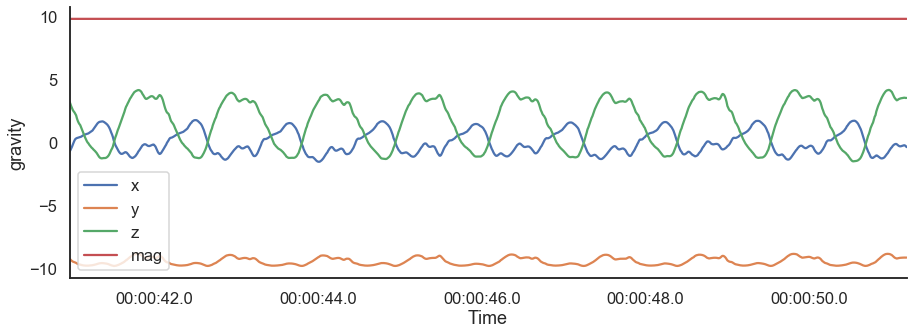

In [9]:
plot_log(chunk, "gravity")

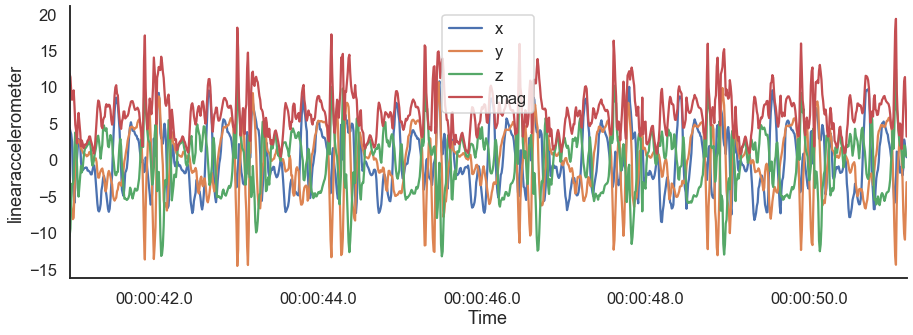

In [10]:
plot_log(chunk, "linearaccelerometer")

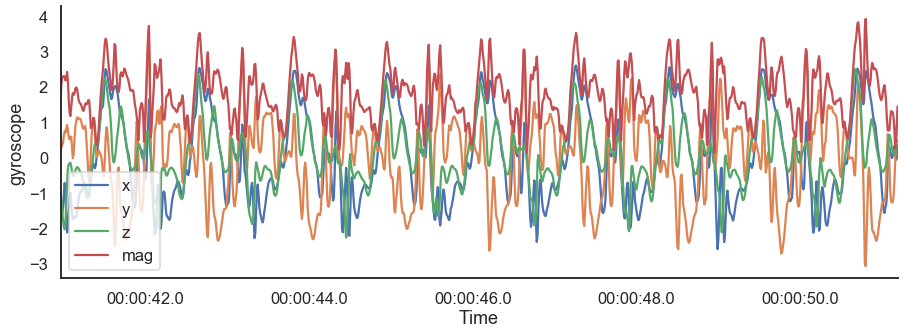

In [11]:
plot_log(chunk, "gyroscope")

## Fourier analysis

In [12]:
def get_normalized_sensor_data(df, logtype):
    norm_acc = np.linalg.norm(df[[f"{logtype}_x_data", f"{logtype}_y_data", f"{logtype}_z_data"]].values, axis=1)
    norm_acc = (norm_acc - norm_acc.mean()) / (np.percentile(norm_acc, 99) - np.percentile(norm_acc, 1))
    return norm_acc

In [13]:
from scipy.fft import fft, ifft  # rfft is real-valued fft, faster
from scipy.signal import correlate, find_peaks

In [14]:
f_s = 1/10e-3  # Sampling rate of 100 measurements/sec
f_s

100.0

In [15]:
def get_fft(signal, f_s):
    """f_s = sampling rate (measurements/second)"""
    T = 1/f_s
    N = len(signal)
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(signal)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])  # take abs (remove phase component)
    return f_values, fft_values

In [16]:
def get_top_signal_peaks(x, y, n):
    peak_idx, peak_props = find_peaks(y, height=0)  # Specify height to force peak height computation
    peak_heights, peak_idx = zip(*sorted(zip(peak_props["peak_heights"], peak_idx), reverse=True)[:n])
    return f_val[list(peak_idx)], np.array(peak_heights)

In [17]:
def plot_fft(f_s, *signals):
    f, ax = plt.subplots(figsize=(15, 5))
    f_vals = []
    fft_vals = []
    for i, signal in enumerate(signals):
        f_val, fft_val = get_fft(signal, f_s)
        f_vals.append(f_val)
        fft_vals.append(fft_val)
        ax.plot(f_val, fft_val, "--" if i%2==1 else "-", label=i)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    ax.legend()
    sns.despine()
    return list(zip(f_vals, fft_vals))

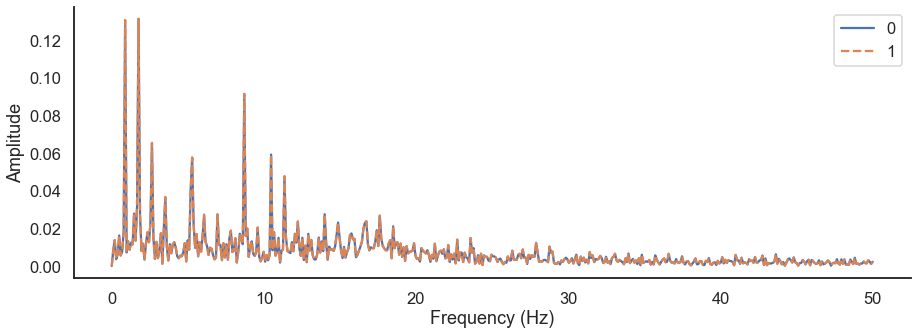

In [18]:
# plot subsequences within the same walk
norm_acc = get_normalized_sensor_data(chunk, "linearaccelerometer")
(f1, fft1), (f2, fft2) = plot_fft(f_s, norm_acc, norm_acc)

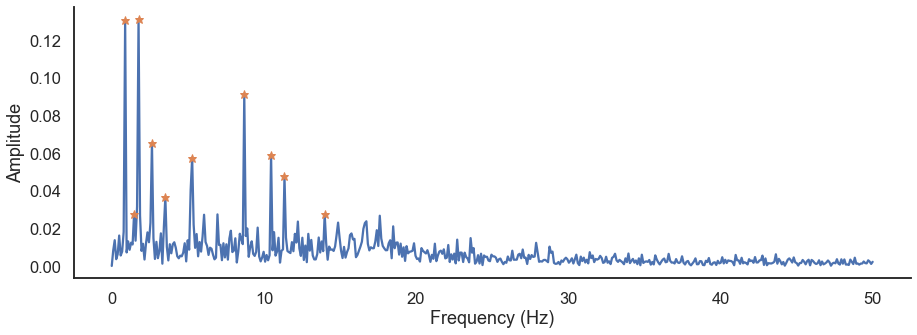

In [19]:
f, ax = plt.subplots(figsize=(15, 5))
f_val, fft_val = get_fft(norm_acc, f_s)
ax.plot(f_val, fft_val)
ax.plot(*get_top_signal_peaks(f1, fft1, 10), "*")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude")
sns.despine()

In [20]:
def plot_product(fft1, fft2):
    f, ax = plt.subplots(figsize=(15, 5))
    ax.plot(f1, fft1 * fft2)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    sns.despine()

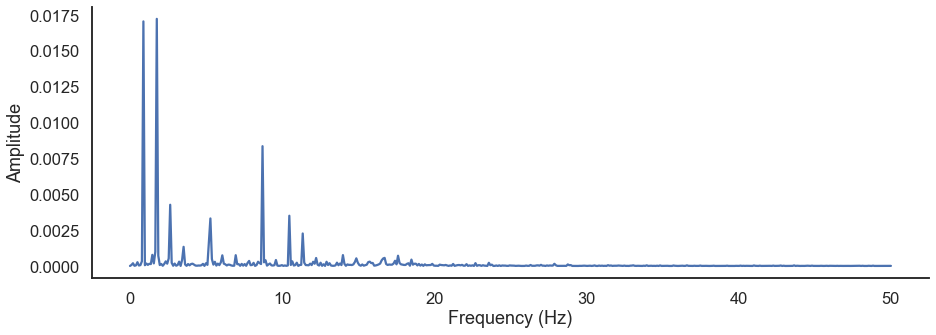

In [21]:
plot_product(fft1, fft2)

## Convert data to feature vectors

- Iterate over users
- Chunk recording information and convert to feature (linearaccelerometer + gyroscope data)
- Label feature with user and walk number

In [22]:
# Get number of walks per user
counts = {}
for folder in IDNET_PATH.glob("*"):
    user_id = int(folder.stem[1:4])
    if user_id not in counts:
        counts[user_id] = 1
    else:
        counts[user_id] += 1

In [23]:
users_with_multiple_walks = [user for user, count in counts.items() if count > 1]
len(users_with_multiple_walks)

31

In [24]:
features = []
for user in tqdm(users_with_multiple_walks):
    for walk in tqdm(range(1, counts[user]+1)):
        df = get_walk_data(user, walk)
        for chunk in generate_walk_chunks(df):
            norm_acc = get_normalized_sensor_data(chunk, "linearaccelerometer")
            norm_gyro = get_normalized_sensor_data(chunk, "gyroscope")
            f_acc, fft_acc = get_fft(norm_acc, f_s)
            peak_f_acc, peak_fft_acc = get_top_signal_peaks(f_acc, fft_acc, 10)
            f_gyro, fft_gyro = get_fft(norm_gyro, f_s)
            peak_f_gyro, peak_fft_gyro = get_top_signal_peaks(f_gyro, fft_gyro, 10)
            # concatenate the features
            feature_vector = np.concatenate([[user, walk], peak_f_acc, peak_fft_acc, peak_f_gyro, peak_fft_gyro])
            features.append(feature_vector)

In [29]:
df = pd.DataFrame(features, 
    columns=["user_id", "walk_id", 
           *[f"acc_f{i}" for i in range(10)], *[f"acc_fft{i}" for i in range(10)],
           *[f"gyro_f{i}" for i in range(10)], *[f"gyro_fft{i}" for i in range(10)]
])
df["user_id"] = df["user_id"].astype(int)
df["walk_id"] = df["walk_id"].astype(int)

In [30]:
df

,user_id,walk_id,acc_f0,acc_f1,acc_f2,acc_f3,acc_f4,acc_f5,acc_f6,acc_f7,...,gyro_fft0,gyro_fft1,gyro_fft2,gyro_fft3,gyro_fft4,gyro_fft5,gyro_fft6,gyro_fft7,gyro_fft8,gyro_fft9
0,1,1,1.761252,2.641879,0.880626,4.598826,4.403131,2.837573,9.099804,1.076321,...,0.160995,0.105686,0.079387,0.050887,0.044985,0.039462,0.038030,0.031356,0.030983,0.030079
1,1,1,2.739726,1.859100,4.598826,0.880626,9.099804,6.360078,7.338552,10.958904,...,0.120327,0.113674,0.078172,0.074543,0.053470,0.052805,0.046099,0.039302,0.038512,0.034547
2,1,1,1.761252,0.880626,2.641879,4.403131,8.708415,6.164384,8.904110,6.947162,...,0.136146,0.110366,0.102315,0.039889,0.037089,0.036454,0.036136,0.030171,0.027448,0.025868
3,1,1,1.859100,2.739726,0.880626,4.500978,9.197652,8.219178,6.457926,15.264188,...,0.111196,0.080614,0.076108,0.073507,0.039090,0.036757,0.036654,0.036616,0.033813,0.031736
4,1,1,1.859100,2.739726,0.880626,4.598826,9.295499,6.457926,7.436399,5.577299,...,0.107595,0.101308,0.074814,0.056992,0.048876,0.046062,0.045739,0.034886,0.032159,0.026318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2073,46,2,0.978474,9.784736,8.806262,1.956947,5.870841,4.892368,10.763209,11.741683,...,0.247891,0.084088,0.071017,0.062063,0.052827,0.045859,0.044168,0.040942,0.035034,0.033813
2074,46,2,0.978474,1.956947,9.686888,10.665362,8.708415,5.870841,4.892368,2.935421,...,0.235064,0.089916,0.082086,0.080407,0.059535,0.055865,0.054566,0.048074,0.045927,0.039169
2075,46,2,0.978474,1.956947,5.870841,2.935421,9.784736,8.806262,6.849315,8.512720,...,0.178344,0.090796,0.054682,0.049599,0.038769,0.038194,0.034925,0.034425,0.031764,0.028743
2076,46,2,0.978474,5.870841,1.956947,9.784736,8.806262,2.935421,10.763209,4.892368,...,0.228235,0.093322,0.075007,0.073563,0.060982,0.060943,0.052889,0.049899,0.048667,0.032553


## Fit data to initial model

- Make sure when splitting into training/test data that we don't mix walks in either set (leakage)

In [38]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [32]:
train = df[df["walk_id"] == 1].copy()
y_train, X_train = train.iloc[:, 0], train.iloc[:, 2:]
test = df[df["walk_id"] != 1].copy()
y_test, X_test = test.iloc[:, 0], test.iloc[:, 2:]

In [33]:
trees = RandomForestClassifier(class_weight="balanced")

In [34]:
trees.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [67]:
train["predicted_user"] = trees.predict(X_train)
test["predicted_user"] = trees.predict(X_test)

In [58]:
cm_test = metrics.confusion_matrix(test["user_id"], test["predicted_user"])

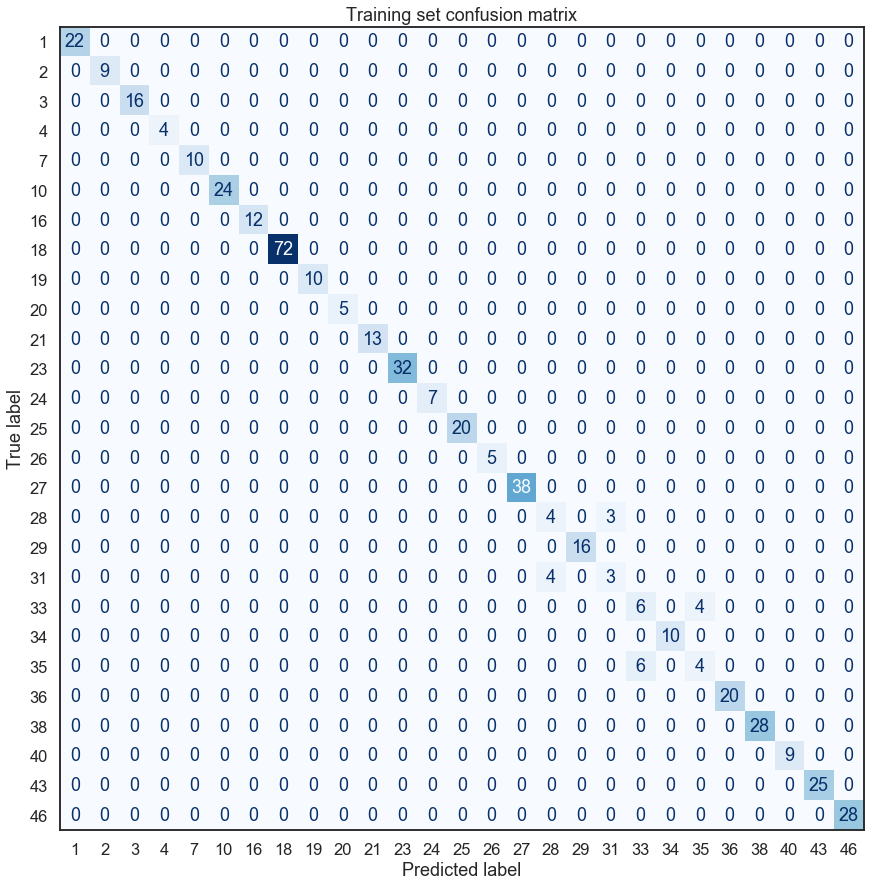

In [73]:
f, ax = plt.subplots(figsize=(18,18))
metrics.plot_confusion_matrix(trees, X_train, y_train, ax=ax, cmap="Blues", values_format="d")
ax.set_title("Training set confusion matrix")
ax.images[-1].colorbar.remove()

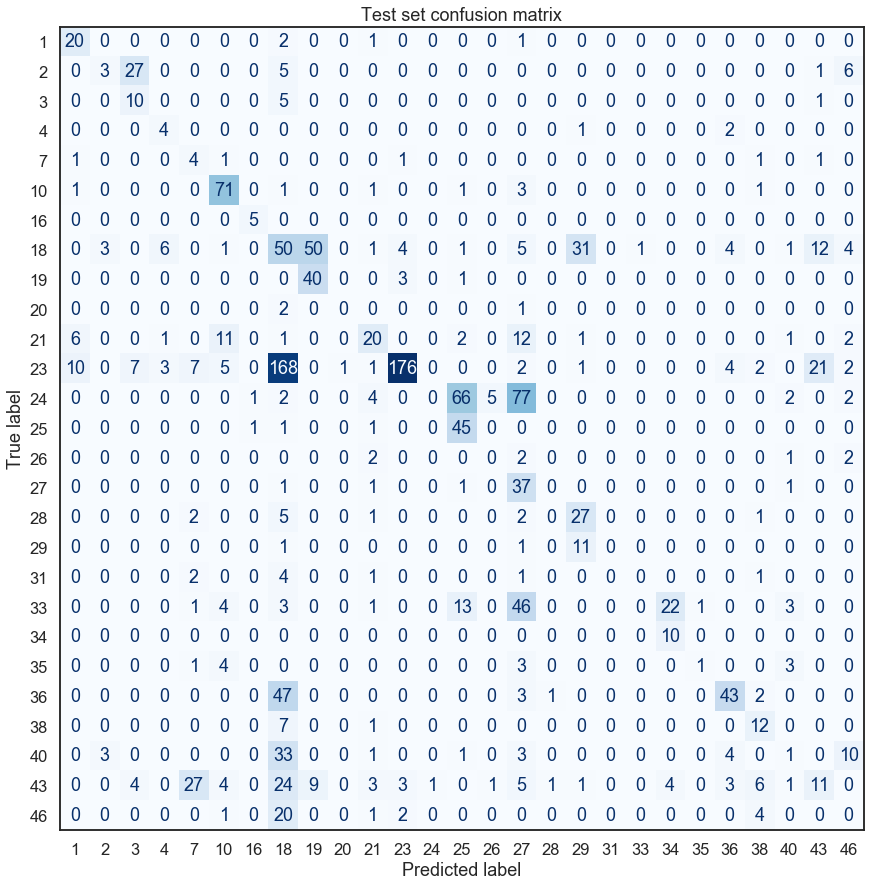

In [72]:
f, ax = plt.subplots(figsize=(18,18))
metrics.plot_confusion_matrix(trees, X_test, y_test, ax=ax, cmap="Blues", values_format="d")
ax.set_title("Test set confusion matrix")
ax.images[-1].colorbar.remove()